In [ ]:
import os
import pandas as pd
import numpy as np
import csv
import ast
from utils_deepcog import compute_local_nr2

# Parameters to iterate over
cities = ['Milan']  # List of cities to iterate over
random_flags = ['False']  # Random flag variations
Ks = [2, 3, 4, 5, 6, 10, 15, 20]
nr2_values = [2, 3, 4, 5, 6, 7]
nr = 21

# Define the main directories
main_dir = '../../../../oracle-data/serly/Scalable_dnn/MAE_plots/DeepCOG_miMo_vs_MiMo/cvs'
lstm_dir = '../../../../oracle-data/serly/Scalable_dnn/MAE_plots/DeepCOG_miMo_vs_MiMo/cvs/LSTM/'

# Initialize variables and dictionaries to store collected data
max_total_cost = 0  # Initialize maximum total cost
data = {}  # Dictionary to store the data
summary_dict = {}  # Dictionary to store summary data for plotting and CSV export later

# First pass: Collect data and compute max_total_cost
for city in cities:
    for random_flag in random_flags:
        for nr2 in nr2_values:
            # Initialize data structures for this combination
            data_key = (city, random_flag, nr2)
            data[data_key] = {
                'total_costs_miMo': {},
                'total_costs_original': {},
                'total_costs_lstm': {},
                'total_costs_miMo_retrained': {}
            }

            # Create dictionaries to store total costs for each K
            total_costs_miMo = {}
            total_costs_original = {}
            total_costs_lstm = {}
            total_costs_miMo_retrained = {}

            # Loop over each K and each cluster_label to process CSV files
            for K in Ks:
                # Initialize sums for each K
                total_costs_miMo[K] = 0
                total_costs_original[K] = 0
                total_costs_lstm[K] = 0
                total_costs_miMo_retrained[K] = 0

                # Iterate over each cluster label (0 to K-1)
                for cluster_label in range(K):
                    # Compute local_nr2
                    local_nr2 = compute_local_nr2(K, nr2, city, nr, cluster_label)

                    # Paths to CSV files
                    csv_path_main = os.path.join(main_dir, f'{city}/{random_flag}/')
                    csv_file = os.path.join(csv_path_main, f'costs_comparison_K_{K}_{cluster_label}_size_{local_nr2}.csv')
                    csv_file_lstm = os.path.join(lstm_dir, f'{city}/{random_flag}/costs_lstm_K_{K}_{cluster_label}_size_{local_nr2}.csv')
                    csv_path_miMo_retrained = os.path.join(main_dir, f'retrained_mimo/{city}/')
                    csv_file_miMo_retrained = os.path.join(csv_path_miMo_retrained, f'costs_comparison_K_{K}_{cluster_label}_size_{local_nr2}.csv')

                    # Check if files exist
                    if not os.path.exists(csv_file):
                        print(f"File not found: {csv_file}")
                        continue
                    if not os.path.exists(csv_file_lstm):
                        print(f"File not found: {csv_file_lstm}")
                        continue
                    if not os.path.exists(csv_file_miMo_retrained):
                        print(f"File not found: {csv_file_miMo_retrained}")
                        continue

                    # Load the CSV data
                    df = pd.read_csv(csv_file)
                    if df.empty:
                        print(f"CSV file is empty: {csv_file}")
                        continue
                    df_lstm = pd.read_csv(csv_file_lstm)
                    if df_lstm.empty:
                        print(f"CSV file is empty: {csv_file_lstm}")
                        continue
                    df_retrained = pd.read_csv(csv_file_miMo_retrained)
                    if df_retrained.empty:
                        print(f"CSV file is empty: {csv_file_miMo_retrained}")
                        continue

                    # Process df (costs_miMo and costs_original)
                    for idx, row in df.iterrows():
                        try:
                            costs_miMo = row['costs_miMo']
                            costs_original = row['costs_original']
                            # Ensure it is a float
                            if not isinstance(costs_miMo, (int, float)):
                                costs_miMo = float(costs_miMo)
                            if not isinstance(costs_original, (int, float)):
                                costs_original = float(costs_original)
                            # Summing total costs
                            total_costs_miMo[K] += costs_miMo
                            total_costs_original[K] += costs_original
                        except (SyntaxError, ValueError, IndexError, TypeError) as e:
                            print(f"Error parsing row {idx} in file {csv_file}: {e}")
                            continue

                    # Process df_lstm (costs_siMo)
                    for idx, row in df_lstm.iterrows():
                        try:
                            costs_lstm = ast.literal_eval(row['costs_siMo'])
                            # Summing total costs
                            total_costs_lstm[K] += costs_lstm[0]
                        except (SyntaxError, ValueError, IndexError, TypeError) as e:
                            print(f"Error parsing row {idx} in file {csv_file_lstm}: {e}")
                            continue

                    # Process df_retrained (costs_miMo)
                    for idx, row in df_retrained.iterrows():
                        try:
                            # Directly handle raw numbers or cast to float
                            costs_miMo_retrained = row['costs_miMo']
                            # Ensure it is a float
                            if not isinstance(costs_miMo_retrained, (int, float)):
                                costs_miMo_retrained = float(costs_miMo_retrained)
                            # Add to total costs
                            total_costs_miMo_retrained[K] += costs_miMo_retrained
                        except (ValueError, TypeError) as e:
                            print(f"Error parsing row {idx} in file {csv_file_miMo_retrained}: {e}")
                            continue

                # Store the total costs in the data dictionary
                data[data_key]['total_costs_miMo'][K] = total_costs_miMo[K]
                data[data_key]['total_costs_original'][K] = total_costs_original[K]
                data[data_key]['total_costs_lstm'][K] = total_costs_lstm[K]
                data[data_key]['total_costs_miMo_retrained'][K] = total_costs_miMo_retrained[K]

# Second pass: Calculate differences and store in summary dictionary
for city in cities:
    for random_flag in random_flags:
        for nr2 in nr2_values:
            data_key = (city, random_flag, nr2)
            total_costs_miMo_retrained = data[data_key]['total_costs_miMo_retrained']
            total_costs_original = data[data_key]['total_costs_original']
            total_costs_miMo = data[data_key]['total_costs_miMo']
            total_costs_lstm = data[data_key]['total_costs_lstm']

            # Store the summary in summary_dict
            for K in Ks:
                if K in total_costs_original and K in total_costs_miMo_retrained and K in total_costs_miMo:
                    original_cost = total_costs_original[K]
                    miMo_cost = total_costs_miMo[K]
                    miMo_enhanced_cost = total_costs_miMo_retrained[K]

                    # Calculate MAE percentage increases
                    mae_percentage_increase_miMo_vs_original = ((miMo_cost - original_cost) / original_cost) * 100 if original_cost != 0 else 0
                    mae_percentage_increase_miMo_enhanced_vs_miMo = ((miMo_enhanced_cost - miMo_cost) / miMo_cost) * 100 if miMo_cost != 0 else 0
                    mae_percentage_increase_miMo_enhanced_vs_original = ((miMo_enhanced_cost - original_cost) / original_cost) * 100 if original_cost != 0 else 0
                    summary_key = (city, random_flag, nr2, K)
                    summary_dict[summary_key] = {
                        'num_cells': nr2,  # Store nr2 value as a representation of num_cells
                        'original_cost': original_cost,
                        'miMo_cost': miMo_cost,
                        'miMo_enhanced_cost': miMo_enhanced_cost,
                        'mae_percentage_increase_miMo_vs_original': mae_percentage_increase_miMo_vs_original,
                        'mae_percentage_increase_miMo_enhanced_vs_miMo': mae_percentage_increase_miMo_enhanced_vs_miMo,
                        'mae_percentage_increase_miMo_enhanced_vs_original': mae_percentage_increase_miMo_enhanced_vs_original
                    }

# Save summary to CSV file
csv_file_path = os.path.join(main_dir, f'mae_increase_summary_{city}.csv')

with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header row
    writer.writerow(['City', 'Random Flag', 'NR2', 'K', 'MAPE miMo vs Original', 'MAPE miMo Enhanced vs miMo', 'MAPE miMo Enhanced vs Original'])
    
    # Write the data rows
    for key, value in summary_dict.items():
        city, random_flag, nr2, K = key
        writer.writerow([
            city,
            random_flag,
            nr2,
            K,
            f"{value['mae_percentage_increase_miMo_vs_original']:.2f}",
            f"{value['mae_percentage_increase_miMo_enhanced_vs_miMo']:.2f}",
            f"{value['mae_percentage_increase_miMo_enhanced_vs_original']:.2f}"
        ])

print(f"\nSummary saved to CSV file: {csv_file_path}")



Summary saved to CSV file: ../../../../oracle-data/serly/Scalable_dnn/MAE_plots/DeepCOG_miMo_vs_MiMo/cvs/mae_increase_summary_Milan.csv


In [ ]:
import os
import pandas as pd
import numpy as np
import csv
import ast
import math
from utils_deepcog import compute_local_nr2, get_rows_Milan

# Parameters to iterate over
cities = ['Milan']  # List of cities to iterate over
random_flags = ['False']  # Random flag variations
Ks = [2, 3, 4, 5, 6, 10, 15, 20]
nr2_values = [2, 3, 4, 5, 6, 7]
nr = 21

# Define the main directories
main_dir = '../../../../oracle-data/serly/Scalable_dnn/MAE_plots/DeepCOG_miMo_vs_MiMo/cvs'
lstm_dir = '../../../../oracle-data/serly/Scalable_dnn/MAE_plots/DeepCOG_miMo_vs_MiMo/cvs/LSTM/'
cluster_directory = '../../../../oracle-data/serly/Scalable_dnn/cluster/'

# Initialize variables and dictionaries to store collected data
data = {}  # Dictionary to store the data
summary_dict = {}  # Dictionary to store summary data for plotting and CSV export later

# First pass: Collect data and compute total costs along with actual number of cells
for city in cities:
    for random_flag in random_flags:
        for nr2 in nr2_values:
            # Initialize data structures for this combination
            data_key = (city, random_flag, nr2)
            data[data_key] = {
                'total_costs_miMo': {},
                'total_costs_original': {},
                'total_costs_lstm': {},
                'total_costs_miMo_retrained': {},
                'actual_num_cells': {}
            }

            # Load cells based on the city
            cells = get_rows_Milan(5060, nr)

            # Loop over each K and each cluster_label to process CSV files
            for K in Ks:
                # Initialize sums for each K
                total_costs_miMo = 0
                total_costs_original = 0
                total_costs_lstm = 0
                total_costs_miMo_retrained = 0
                local_sum_cells = 0

                # Load cluster data
                cluster_counts = np.load(cluster_directory + f'clusters_{city}_{K}.npy')

                # Initialize a dictionary to store the cell IDs for each cluster
                clustered_cells = {i: [] for i in range(K)}

                # Categorize the cells into clusters
                for idx, cluster_label in enumerate(cluster_counts):
                    cell_id = cells[idx]
                    clustered_cells[cluster_label].append(cell_id)

                # Iterate over each cluster label (0 to K-1)
                for cluster_label in range(K):
                    # Compute local_nr2 and determine actual number of cells
                    local_nr2 = nr2
                    local_num_cells = nr2 * nr2
                    cluster_cells = clustered_cells.get(cluster_label, [])

                    if not cluster_cells:
                        print(f"No cells found for Cluster {cluster_label}")
                        continue

                    total_cells = len(cluster_cells)

                    # Ensure num_cells is a square number and <= total_cells
                    if local_num_cells > total_cells:
                        largest_square = int(math.floor(math.sqrt(total_cells))) ** 2
                        local_num_cells = largest_square
                        local_nr2 = int(math.sqrt(local_num_cells))

                    # Accumulate local_num_cells to the local sum for this cluster
                    local_sum_cells += local_num_cells

                    # Paths to CSV files
                    csv_path_main = os.path.join(main_dir, f'{city}/{random_flag}/')
                    csv_file = os.path.join(csv_path_main, f'costs_comparison_K_{K}_{cluster_label}_size_{local_nr2}.csv')
                    csv_file_lstm = os.path.join(lstm_dir, f'{city}/{random_flag}/costs_lstm_K_{K}_{cluster_label}_size_{local_nr2}.csv')
                    csv_path_miMo_retrained = os.path.join(main_dir, f'retrained_mimo/{city}/')
                    csv_file_miMo_retrained = os.path.join(csv_path_miMo_retrained, f'costs_comparison_K_{K}_{cluster_label}_size_{local_nr2}.csv')

                    # Check if files exist
                    if not os.path.exists(csv_file):
                        print(f"File not found: {csv_file}")
                        continue
                    if not os.path.exists(csv_file_lstm):
                        print(f"File not found: {csv_file_lstm}")
                        continue
                    if not os.path.exists(csv_file_miMo_retrained):
                        print(f"File not found: {csv_file_miMo_retrained}")
                        continue

                    # Load the CSV data
                    df = pd.read_csv(csv_file)
                    df_lstm = pd.read_csv(csv_file_lstm)
                    df_retrained = pd.read_csv(csv_file_miMo_retrained)

                    if df.empty or df_lstm.empty or df_retrained.empty:
                        print(f"CSV file is empty: {csv_file}")
                        continue

                    # Process df (costs_miMo and costs_original)
                    for idx, row in df.iterrows():
                        try:
                            total_costs_miMo += float(row['costs_miMo'])
                            total_costs_original += float(row['costs_original'])
                        except Exception as e:
                            print(f"Error parsing row {idx} in file {csv_file}: {e}")
                            continue

                    # Process df_lstm (costs_siMo)
                    for idx, row in df_lstm.iterrows():
                        try:
                            total_costs_lstm += ast.literal_eval(row['costs_siMo'])[0]
                        except Exception as e:
                            print(f"Error parsing row {idx} in file {csv_file_lstm}: {e}")
                            continue

                    # Process df_retrained (costs_miMo)
                    for idx, row in df_retrained.iterrows():
                        try:
                            total_costs_miMo_retrained += float(row['costs_miMo'])
                        except Exception as e:
                            print(f"Error parsing row {idx} in file {csv_file_miMo_retrained}: {e}")
                            continue

                # Store the total costs and actual number of cells in the data dictionary
                data[data_key]['total_costs_miMo'][K] = total_costs_miMo
                data[data_key]['total_costs_original'][K] = total_costs_original
                data[data_key]['total_costs_lstm'][K] = total_costs_lstm
                data[data_key]['total_costs_miMo_retrained'][K] = total_costs_miMo_retrained
                data[data_key]['actual_num_cells'][K] = local_sum_cells

# Second pass: Calculate differences and store in summary dictionary
for city in cities:
    for random_flag in random_flags:
        for nr2 in nr2_values:
            data_key = (city, random_flag, nr2)
            total_costs_miMo_retrained = data[data_key]['total_costs_miMo_retrained']
            total_costs_original = data[data_key]['total_costs_original']
            total_costs_miMo = data[data_key]['total_costs_miMo']
            actual_num_cells = data[data_key]['actual_num_cells']

            # Store the summary in summary_dict
            for K in Ks:
                if K in total_costs_original and K in total_costs_miMo_retrained and K in total_costs_miMo:
                    original_cost = total_costs_original[K]
                    miMo_cost = total_costs_miMo[K]
                    miMo_enhanced_cost = total_costs_miMo_retrained[K]

                    # Calculate MAE percentage increases
                    mae_percentage_increase_miMo_vs_original = ((miMo_cost - original_cost) / original_cost) * 100 if original_cost != 0 else 0
                    mae_percentage_increase_miMo_enhanced_vs_miMo = ((miMo_enhanced_cost - miMo_cost) / miMo_cost) * 100 if miMo_cost != 0 else 0
                    mae_percentage_increase_miMo_enhanced_vs_original = ((miMo_enhanced_cost - original_cost) / original_cost) * 100 if original_cost != 0 else 0

                    # Store values in the summary dictionary
                    summary_key = (city, random_flag, nr2, K)
                    summary_dict[summary_key] = {
                        'num_cells': nr2,
                        'actual_num_cells': actual_num_cells[K],  # Add actual number of cells
                        'original_cost': original_cost,
                        'miMo_cost': miMo_cost,
                        'miMo_enhanced_cost': miMo_enhanced_cost,
                        'mae_percentage_increase_miMo_vs_original': mae_percentage_increase_miMo_vs_original,
                        'mae_percentage_increase_miMo_enhanced_vs_miMo': mae_percentage_increase_miMo_enhanced_vs_miMo,
                        'mae_percentage_increase_miMo_enhanced_vs_original': mae_percentage_increase_miMo_enhanced_vs_original
                    }

# Save summary to CSV file
csv_file_path = os.path.join(main_dir, f'mae_increase_summary_with_cells_{city}.csv')

with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header row
    writer.writerow(['City', 'Random Flag', 'NR2', 'K', 'Actual Num Cells', 'MAPE miMo vs Original', 'MAPE miMo Enhanced vs miMo', 'MAPE miMo Enhanced vs Original'])
    
    # Write the data rows
    for key, value in summary_dict.items():
        city, random_flag, nr2, K = key
        writer.writerow([
            city,
            random_flag,
            nr2,
            K,
            value['actual_num_cells'],
            f"{value['mae_percentage_increase_miMo_vs_original']:.2f}",
            f"{value['mae_percentage_increase_miMo_enhanced_vs_miMo']:.2f}",
            f"{value['mae_percentage_increase_miMo_enhanced_vs_original']:.2f}"
        ])

print(f"\nSummary saved to CSV file: {csv_file_path}")



Summary saved to CSV file: ../../../../oracle-data/serly/Scalable_dnn/MAE_plots/DeepCOG_miMo_vs_MiMo/cvs/mae_increase_summary_with_cells_Milan.csv


create summary csv for the baseline being the lstm per BS

In [ ]:
import os
import pandas as pd
import numpy as np
import csv
import ast
import math
from utils_deepcog import compute_local_nr2, get_rows_Milan

# Parameters to iterate over
cities = ['Milan']  # List of cities to iterate over
random_flags = ['False']  # Random flag variations
Ks = [2, 3, 4, 5, 6, 10, 15, 20]
nr2_values = [2, 3, 4, 5, 6, 7]
nr = 21

# Define the main directories
main_dir = '../../../../oracle-data/serly/Scalable_dnn/MAE_plots/DeepCOG_miMo_vs_MiMo/cvs'
lstm_dir = '../../../../oracle-data/serly/Scalable_dnn/MAE_plots/DeepCOG_miMo_vs_MiMo/cvs/LSTM/'
cluster_directory = '../../../../oracle-data/serly/Scalable_dnn/cluster/'

# Initialize variables and dictionaries to store collected data
data = {}  # Dictionary to store the data
summary_dict = {}  # Dictionary to store summary data for plotting and CSV export later

# First pass: Collect data and compute total costs along with actual number of cells
for city in cities:
    for random_flag in random_flags:
        for nr2 in nr2_values:
            # Initialize data structures for this combination
            data_key = (city, random_flag, nr2)
            data[data_key] = {
                'total_costs_miMo': {},
                'total_costs_original': {},
                'total_costs_lstm': {},
                'total_costs_miMo_retrained': {},
                'actual_num_cells': {}
            }

            # Load cells based on the city
            cells = get_rows_Milan(5060, nr)

            # Loop over each K and each cluster_label to process CSV files
            for K in Ks:
                # Initialize sums for each K
                total_costs_miMo = 0
                total_costs_original = 0
                total_costs_lstm = 0
                total_costs_miMo_retrained = 0
                local_sum_cells = 0

                # Load cluster data
                cluster_counts = np.load(cluster_directory + f'clusters_{city}_{K}.npy')

                # Initialize a dictionary to store the cell IDs for each cluster
                clustered_cells = {i: [] for i in range(K)}

                # Categorize the cells into clusters
                for idx, cluster_label in enumerate(cluster_counts):
                    cell_id = cells[idx]
                    clustered_cells[cluster_label].append(cell_id)

                # Iterate over each cluster label (0 to K-1)
                for cluster_label in range(K):
                    # Compute local_nr2 and determine actual number of cells
                    local_nr2 = nr2
                    local_num_cells = nr2 * nr2
                    cluster_cells = clustered_cells.get(cluster_label, [])

                    if not cluster_cells:
                        print(f"No cells found for Cluster {cluster_label}")
                        continue

                    total_cells = len(cluster_cells)

                    # Ensure num_cells is a square number and <= total_cells
                    if local_num_cells > total_cells:
                        largest_square = int(math.floor(math.sqrt(total_cells))) ** 2
                        local_num_cells = largest_square
                        local_nr2 = int(math.sqrt(local_num_cells))

                    # Accumulate local_num_cells to the local sum for this cluster
                    local_sum_cells += local_num_cells

                    # Paths to CSV files
                    csv_path_main = os.path.join(main_dir, f'{city}/{random_flag}/')
                    csv_file = os.path.join(csv_path_main, f'costs_comparison_K_{K}_{cluster_label}_size_{local_nr2}.csv')
                    csv_file_lstm = os.path.join(lstm_dir, f'{city}/{random_flag}/costs_lstm_K_{K}_{cluster_label}_size_{local_nr2}.csv')
                    csv_path_miMo_retrained = os.path.join(main_dir, f'retrained_mimo/{city}/')
                    csv_file_miMo_retrained = os.path.join(csv_path_miMo_retrained, f'costs_comparison_K_{K}_{cluster_label}_size_{local_nr2}.csv')

                    # Check if files exist
                    if not os.path.exists(csv_file):
                        print(f"File not found: {csv_file}")
                        continue
                    if not os.path.exists(csv_file_lstm):
                        print(f"File not found: {csv_file_lstm}")
                        continue
                    if not os.path.exists(csv_file_miMo_retrained):
                        print(f"File not found: {csv_file_miMo_retrained}")
                        continue

                    # Load the CSV data
                    df = pd.read_csv(csv_file)
                    df_lstm = pd.read_csv(csv_file_lstm)
                    df_retrained = pd.read_csv(csv_file_miMo_retrained)

                    if df.empty or df_lstm.empty or df_retrained.empty:
                        print(f"CSV file is empty: {csv_file}")
                        continue

                    # Process df (costs_miMo and costs_original)
                    for idx, row in df.iterrows():
                        try:
                            total_costs_miMo += float(row['costs_miMo'])
                            total_costs_original += float(row['costs_original'])
                        except Exception as e:
                            print(f"Error parsing row {idx} in file {csv_file}: {e}")
                            continue

                    # Process df_lstm (costs_siMo)
                    for idx, row in df_lstm.iterrows():
                        try:
                            total_costs_lstm += ast.literal_eval(row['costs_siMo'])[0]
                        except Exception as e:
                            print(f"Error parsing row {idx} in file {csv_file_lstm}: {e}")
                            continue

                    # Process df_retrained (costs_miMo)
                    for idx, row in df_retrained.iterrows():
                        try:
                            total_costs_miMo_retrained += float(row['costs_miMo'])
                        except Exception as e:
                            print(f"Error parsing row {idx} in file {csv_file_miMo_retrained}: {e}")
                            continue

                # Store the total costs and actual number of cells in the data dictionary
                data[data_key]['total_costs_miMo'][K] = total_costs_miMo
                data[data_key]['total_costs_original'][K] = total_costs_original
                data[data_key]['total_costs_lstm'][K] = total_costs_lstm
                data[data_key]['total_costs_miMo_retrained'][K] = total_costs_miMo_retrained
                data[data_key]['actual_num_cells'][K] = local_sum_cells

# Second pass: Calculate differences and store in summary dictionary
for city in cities:
    for random_flag in random_flags:
        for nr2 in nr2_values:
            data_key = (city, random_flag, nr2)
            total_costs_miMo_retrained = data[data_key]['total_costs_miMo_retrained']
            total_costs_original = data[data_key]['total_costs_original']
            total_costs_miMo = data[data_key]['total_costs_miMo']
            actual_num_cells = data[data_key]['actual_num_cells']
            perbs_cost = 7.84e+03
            # Store the summary in summary_dict
            for K in Ks:
                if K in total_costs_original and K in total_costs_miMo_retrained and K in total_costs_miMo:
                    original_cost = total_costs_original[K]
                    miMo_cost = total_costs_miMo[K]
                    miMo_enhanced_cost = total_costs_miMo_retrained[K]
                    
                    # Calculate MAE percentage increases
                    mae_percentage_increase_miMo_vs_perbs = ((miMo_cost - perbs_cost) / perbs_cost) * 100 if perbs_cost != 0 else 0
                    mae_percentage_increase_miMo_enhanced_vs_miMo = ((miMo_enhanced_cost - miMo_cost) / miMo_cost) * 100 if miMo_cost != 0 else 0
                    mae_percentage_increase_miMo_enhanced_vs_perbs = ((miMo_enhanced_cost - perbs_cost) / perbs_cost) * 100 if perbs_cost != 0 else 0
                    mae_percentage_increase_original_vs_perbs = ((original_cost - perbs_cost) / perbs_cost) * 100 if perbs_cost != 0 else 0
                    # Store values in the summary dictionary
                    summary_key = (city, random_flag, nr2, K)
                    summary_dict[summary_key] = {
                        'num_cells': nr2,
                        'actual_num_cells': actual_num_cells[K],  # Add actual number of cells
                        'original_cost': perbs_cost,
                        'miMo_cost': miMo_cost,
                        'miMo_enhanced_cost': miMo_enhanced_cost,
                        'mae_percentage_increase_miMo_vs_perbs': mae_percentage_increase_miMo_vs_perbs,
                        'mae_percentage_increase_miMo_enhanced_vs_miMo': mae_percentage_increase_miMo_enhanced_vs_miMo,
                        'mae_percentage_increase_miMo_enhanced_vs_perbs': mae_percentage_increase_miMo_enhanced_vs_perbs,
                        'mae_percentage_increase_original_vs_perbs': mae_percentage_increase_original_vs_perbs
                    }

# Save summary to CSV file
csv_file_path = os.path.join(main_dir, f'mae_increase_summary_with_cells_{city}_PerBS.csv')

with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header row
    writer.writerow(['City', 'Random Flag', 'NR2', 'K', 'Actual Num Cells', 'MAPE miMo vs PerBS', 'MAPE miMo Enhanced vs miMo', 'MAPE miMo Enhanced vs PerBS', 'MAPE Original vs PerBS'])
    
    # Write the data rows
    for key, value in summary_dict.items():
        city, random_flag, nr2, K = key
        writer.writerow([
            city,
            random_flag,
            nr2,
            K,
            value['actual_num_cells'],
            f"{value['mae_percentage_increase_miMo_vs_perbs']:.2f}",
            f"{value['mae_percentage_increase_miMo_enhanced_vs_miMo']:.2f}",
            f"{value['mae_percentage_increase_miMo_enhanced_vs_perbs']:.2f}",
            f"{value['mae_percentage_increase_original_vs_perbs']:.2f}"
        ])

print(f"\nSummary saved to CSV file: {csv_file_path}")



Summary saved to CSV file: ../../../../oracle-data/serly/Scalable_dnn/MAE_plots/DeepCOG_miMo_vs_MiMo/cvs/mae_increase_summary_with_cells_Paris_PerBS.csv


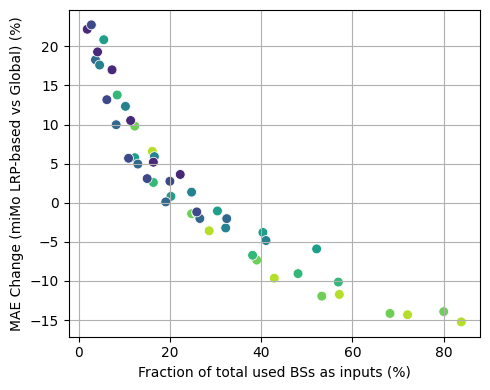

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters to iterate over
city = 'Milan'  

# File path to the updated CSV
csv_file_path = f'../../../../oracle-data/serly/Scalable_dnn/MAE_plots/DeepCOG_miMo_vs_MiMo/cvs/mae_increase_summary_with_cells_{city}.csv'

# Step 1: Load the updated CSV
df = pd.read_csv(csv_file_path)

# Ensure all relevant columns are numeric for plotting
df['K'] = pd.to_numeric(df['K'])
df['NR2'] = pd.to_numeric(df['NR2'])
df['Actual Num Cells'] = pd.to_numeric(df['Actual Num Cells'])
df['MAPE miMo Enhanced vs Original'] = pd.to_numeric(df['MAPE miMo Enhanced vs Original'])

# Step 2: Calculate Fraction Reduced Inputs
total_cells = 441  # Baseline total number of cells in the 21x21 grid
df['Fraction Reduced (%)'] = 100 - (((total_cells - df['Actual Num Cells']) / total_cells) * 100)

# Step 3: Use MAE Decrease directly without negating it (assuming negative values indicate decrease)
df['MAE Decrease (%)'] = df['MAPE miMo Enhanced vs Original']

# Step 4: Convert K to categorical for plotting clarity
df['K'] = df['K'].astype('category')

# Step 5: Scatter Plot: Fraction Reduced Inputs vs MAE Decrease, color-coded by K
plt.figure(figsize=(5, 4))
sns.scatterplot(
    data=df,
    x='Fraction Reduced (%)',
    y='MAE Decrease (%)',
    hue='K',  # Different colors for different values of K
    palette='viridis',
    alpha=1,
    s=50,  # Size of the scatter points
    legend=False  # Disable the legend
)

# Adding labels and titles to the plot
plt.xlabel('Fraction of total used BSs as inputs (%)', fontsize=10)
plt.ylabel('MAE Change (miMo LRP-based vs Global) (%)')
# plt.title(f'Effect of Reduced Inputs on MAE for {city}')
plt.grid(True)
plt.tight_layout()

# Save the scatter plot without the legend
plt.savefig(f'../../../../oracle-data/serly/Scalable_dnn/MAE_plots/DeepCOG_miMo_vs_MiMo/cvs/mae_vs_fraction_{city}_without_legend.pdf', dpi=300, bbox_inches='tight')
plt.show()


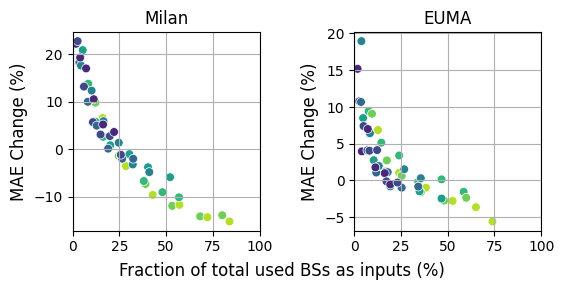

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters to iterate over
cities = ['Milan']

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=False)

for ax, city in zip(axes, cities):
    # File path to the updated CSV for each city
    csv_file_path = f'../../../../oracle-data/serly/Scalable_dnn/MAE_plots/DeepCOG_miMo_vs_MiMo/cvs/mae_increase_summary_with_cells_{city}.csv'
    
    # Load the updated CSV
    df = pd.read_csv(csv_file_path)
    
    # Ensure all relevant columns are numeric for plotting
    df['K'] = pd.to_numeric(df['K'])
    df['NR2'] = pd.to_numeric(df['NR2'])
    df['Actual Num Cells'] = pd.to_numeric(df['Actual Num Cells'])
    df['MAPE miMo Enhanced vs Original'] = pd.to_numeric(df['MAPE miMo Enhanced vs Original'])
    
    # Calculate Fraction Reduced Inputs
    total_cells = 441  # Baseline total number of cells in the 21x21 grid
    df['Fraction Reduced (%)'] = 100 - (((total_cells - df['Actual Num Cells']) / total_cells) * 100)
    
    # Use MAE Decrease directly without negating it (assuming negative values indicate decrease)
    df['MAE Decrease (%)'] = df['MAPE miMo Enhanced vs Original']
    
    # Convert K to categorical for plotting clarity
    df['K'] = df['K'].astype('category')
    
    # Scatter Plot: Fraction Reduced Inputs vs MAE Decrease, color-coded by K
    sns.scatterplot(
        data=df,
        x='Fraction Reduced (%)',
        y='MAE Decrease (%)',
        hue='K',  # Different colors for different values of K
        palette='viridis',
        alpha=1,
        s=40,  # Size of the scatter points
        ax=ax,
        legend=False  # Disable the legend
    )
    
    # Adding labels and titles to the plot
    ax.set_xlabel('')
    ax.set_ylabel('MAE Change (%)', fontsize=12)
    ax.set_xlim(0, 100)
    ax.grid(True)
    ax.set_title('Milan')  # Add customized title

# Set a global x-label for the entire figure with some padding
fig.text(0.5, 0.02, 'Fraction of total used BSs as inputs (%)', ha='center', fontsize=12)

# Adjust layout and save the figure
plt.tight_layout(pad=2.0)
plt.savefig(f'../../../../oracle-data/serly/Scalable_dnn/MAE_plots/DeepCOG_miMo_vs_MiMo/cvs/mae_vs_fraction_Milan_EUMA.pdf', dpi=300, bbox_inches='tight')
plt.show()


Scatter baseline being PerBS

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


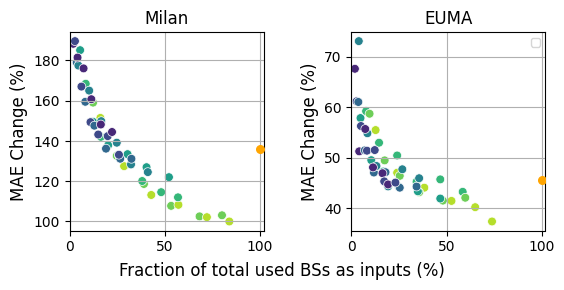

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters to iterate over
cities = ['Milan']

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=False)

for ax, city in zip(axes, cities):
    # File path to the updated CSV for each city
    csv_file_path = f'../../../../oracle-data/serly/Scalable_dnn/MAE_plots/DeepCOG_miMo_vs_MiMo/cvs/mae_increase_summary_with_cells_{city}_PerBS.csv'
    
    # Load the updated CSV
    df = pd.read_csv(csv_file_path)
    
    # Ensure all relevant columns are numeric for plotting
    df['K'] = pd.to_numeric(df['K'])
    df['NR2'] = pd.to_numeric(df['NR2'])
    df['Actual Num Cells'] = pd.to_numeric(df['Actual Num Cells'])
    df['MAPE miMo Enhanced vs PerBS'] = pd.to_numeric(df['MAPE miMo Enhanced vs PerBS'])
    df['MAPE Original vs PerBS'] = pd.to_numeric(df['MAPE Original vs PerBS'])
    
    # Calculate Fraction Reduced Inputs
    total_cells = 441  # Baseline total number of cells in the 21x21 grid
    df['Fraction Reduced (%)'] = 100 - (((total_cells - df['Actual Num Cells']) / total_cells) * 100)
    
    # Use MAE Decrease directly without negating it (assuming negative values indicate decrease)
    df['MAE Decrease (%)'] = df['MAPE miMo Enhanced vs PerBS']
    
    # Convert K to categorical for plotting clarity
    df['K'] = df['K'].astype('category')
    
    # Scatter Plot: Fraction Reduced Inputs vs MAE Decrease, color-coded by K
    sns.scatterplot(
        data=df,
        x='Fraction Reduced (%)',
        y='MAE Decrease (%)',
        hue='K',  # Different colors for different values of K
        palette='viridis',
        alpha=1,
        s=40,  # Size of the scatter points
        ax=ax,
        legend=False  # Disable the legend
    )
    
    # Plot a single dot for MAPE Original vs PerBS at Fraction Reduced (%) = 100
    ax.scatter(
        x=[100],  # Fraction Reduced = 100
        y=[df['MAPE Original vs PerBS'].iloc[0]],  # First row of MAPE Original vs PerBS
        color='orange',
        s=30,  # Size of the dot
        zorder=5  # Bring it to the foreground
    )
    
    # Adding labels and titles to the plot
    ax.set_xlabel('')
    ax.set_ylabel('MAE Change (%)', fontsize=12)
    ax.set_xlim(0, 102)
    ax.grid(True)
    ax.set_title('Milan')  # Add customized title

# Set a global x-label for the entire figure with some padding
fig.text(0.5, 0.02, 'Fraction of total used BSs as inputs (%)', ha='center', fontsize=12)

# Add a global legend for the dot
axes[1].legend(loc='best', fontsize=8)

# Adjust layout and save the figure
plt.tight_layout(pad=2.0)
plt.savefig(f'../../../../oracle-data/serly/Scalable_dnn/MAE_plots/DeepCOG_miMo_vs_MiMo/cvs/mae_vs_fraction_Milan_EUMA_PerBS.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters to iterate over
city = 'Milan'

# File path to the updated CSV
csv_file_path = f'../../../../oracle-data/serly/Scalable_dnn/MAE_plots/DeepCOG_miMo_vs_MiMo/cvs/mae_increase_summary_with_cells_{city}.csv'

# Step 1: Load the updated CSV
df = pd.read_csv(csv_file_path)

# Ensure all relevant columns are numeric for plotting
df['K'] = pd.to_numeric(df['K'])
df['NR2'] = pd.to_numeric(df['NR2'])
df['Actual Num Cells'] = pd.to_numeric(df['Actual Num Cells'])
df['MAPE miMo Enhanced vs Original'] = pd.to_numeric(df['MAPE miMo Enhanced vs Original'])

# Step 2: Calculate Fraction Reduced Inputs
total_cells = 441  # Baseline total number of cells in the 21x21 grid
df['Fraction Reduced (%)'] = 100 - (((total_cells - df['Actual Num Cells']) / total_cells) * 100)

# Step 3: Use MAE Decrease directly without negating it (assuming negative values indicate decrease)
df['MAE Decrease (%)'] = df['MAPE miMo Enhanced vs Original']

# Step 4: Convert K to categorical for plotting clarity
df['K'] = df['K'].astype('category')

# Step 5: Scatter Plot: Fraction Reduced Inputs vs MAE Decrease, color-coded by K
plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(
    data=df,
    x='Fraction Reduced (%)',
    y='MAE Decrease (%)',
    hue='K',  # Different colors for different values of K
    palette='viridis',
    alpha=0.7,
    s=70  # Size of the scatter points
)

# Adding labels and titles to the plot
plt.xlabel('Fraction of total used BSs as inputs (%)', fontsize=12)
plt.ylabel('MAE Change (miMo LRP-based vs Global) (%)', fontsize=12)
plt.grid(True)
plt.close()
# Remove the legend from the scatter plot
scatter.legend_.remove()

# Step 6: Create a Separate Figure for the Legend Only
# Create a new figure to draw the legend
fig_legend = plt.figure(figsize=(6, 3))

# Extract the legend from the original scatter plot
handles, labels = scatter.get_legend_handles_labels()

# Add the legend to the new figure
fig_legend.legend(handles, labels, title='Number of Clusters (K)', loc='center', fontsize='medium', title_fontsize='large', ncol=8)

# Save the legend as a separate file
legend_output_path = f'../../../../oracle-data/serly/Scalable_dnn/MAE_plots/DeepCOG_miMo_vs_MiMo/cvs/legend_scatter.pdf'
fig_legend.savefig(legend_output_path, dpi=300, bbox_inches='tight')
plt.show()


<Figure size 600x300 with 0 Axes>